# 🏆️ Competição de Reconhecimento de Faces - IFSP Campinas  (Entrega: Lucas Piero, CP3016315)

## Introdução

Este Jupyter Notebook apresenta nossa abordagem para a competição de Reconhecimento de Faces do Instituto Federal de São Paulo (IFSP) - Campus Campinas, realizada como parte das atividades avaliativas da disciplina Aplicações em Ciência de Dados (D3APL 2023), integrante do curso de Especialização em Ciência de Dados. 

Link para competição: https://www.kaggle.com/competitions/ifsp-d3apl-2023-face-recognition/overview

O principal objetivo deste trabalho é criar um modelo de rede neural capaz de identificar corretamente os rostos de 83 indivíduos a partir de imagens fornecidas. Para alcançar esse objetivo, vamos usar técnicas avançadas de aprendizado de máquina e processamento de imagens.

## 🎯 Objetivo

Nosso objetivo é desenvolver um modelo de aprendizado de máquina, particularmente uma rede neural, que seja capaz de identificar corretamente um rosto em uma imagem. A partir de uma imagem dada, nosso modelo deve determinar corretamente a quem o rosto pertence, dentre um total de 83 possíveis pessoas.

## 🗄️ Dataset

Para treinar e avaliar nosso modelo, vamos utilizar o conjunto de dados PubFig83, que contém imagens coloridas de rostos de 83 artistas, totalizando 13.840 imagens coletadas da internet. Todas as imagens foram previamente redimensionadas para 100x100 pixels e alinhadas de acordo com a posição dos olhos das pessoas retratadas.

O conjunto de dados de treinamento, denominado `train.zip` e `train.csv`, contém um total de 12.180 imagens rotuladas, distribuídas em 83 classes (pessoas).

O desempenho do nosso modelo será avaliado usando um conjunto de testes não rotulado, contendo um total de 1.660 imagens, chamado `test.zip` e `test.csv`.

## Metodologia

1. Pré-processamento dos dados
2. Construção e avaliação de modelos para comparação
3. Treinamento do modelo final

Esta abordagem servirá como um roteiro para a nossa investigação. Agora, vamos começar a explorar nossos dados!


# 0. Imports

In [5]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D,Dropout, Flatten, Activation, BatchNormalization
from keras.applications import ResNet50, VGG16
from keras.layers import GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
from time import perf_counter
import seaborn as sns
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Pré-processamento dos dados

## 1.1 Usando a GPU

### 💡 Dica Importante: Aceleração de GPU com a NVIDIA

Se você está interessado em utilizar uma placa de vídeo NVIDIA para acelerar seus treinamentos, pode encontrar algumas dificuldades na etapa de instalação. Muitos de nós passamos dias testando vários tutoriais sem muito sucesso. Porém, descobrimos um guia que se provou eficaz. 

O seguinte [Tutorial](https://www.skooterblog.com/2022/12/26/tensorflow-2-10-no-windows-com-suporte-a-gpu-via-condapip-tensorflow-addons-e-spyder/) descreve em detalhes como instalar e configurar o TensorFlow 2.10 no Windows com suporte a GPU, utilizando Conda, Pip, TensorFlow Addons. Este recurso pode ser extremamente útil para quem deseja aproveitar ao máximo o poder de processamento da sua GPU NVIDIA. 

Observe que isso só funciona para o desenvolvimento no jupyter. No Vscode não funcionou.

Não deixe de conferir se essa é uma opção viável para você e seu projeto!


In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.2 Leitura dos dados

Note que durante o desenvolvimento deste trabalho iremos utilizar o conceito de transfer learning, neste sentido é importante configurar as imagens para o formato adequado dos modelos desejados, sendo assim vamos criar funções para que as bases de treino e teste sejam geradas baseados no `input_shape`

In [2]:
def gerar_treino_teste(rows,cols):
    # read the dataframe
    df = pd.read_csv('train.csv')
    
    # iterate over the images
    for i, row in df.iterrows():
        # read the image
        img = cv2.imread(row['image-pathname'])

        # check if the image was correctly opened
        if img is not None:
            # resize the image
            img = cv2.resize(img, (rows, cols))

            # save the image back to disk
            cv2.imwrite(row['image-pathname'], img)
        else:
            print(f"Image not found: {row['image-pathname']}")
    
    # training a Label Encoder from the train set

    #label_encoder = LabelEncoder()
    #label_encoder.fit(df['label'])
    #df["new_label"] = df.apply(lambda x: label_encoder.transform([x["label"]])[0], axis = 1)
    labels = df['label']
    
    dataset_df_full_train, dataset_df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=labels)
    
    #Gerar dados de treinamento
    train_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=30,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
                                 
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(dataframe=dataset_df_full_train,
                                                        x_col="image-pathname",
                                                        y_col="label",
                                                        target_size=(rows,cols),
                                                        class_mode='categorical')

    test_generator = test_datagen.flow_from_dataframe( dataframe=dataset_df_test,
                                                        x_col="image-pathname",
                                                        y_col="label",
                                                        target_size=(rows,cols),
                                                        class_mode='categorical')
    
    
    
    
    return train_generator, test_generator

In [24]:
train, test = gerar_treino_teste(100,100)

Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.


# 2. Construção e avaliação de modelos para comparação

In [25]:
def graficos(history):
    history_df = pd.DataFrame(history.history)
    history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Score')

## 2.1 Modelo básico retirado da aula

In [20]:
def build_cnn(input_shape=(100, 100, 3), n_classes=83):
    model = Sequential([
        # feature extraction
        Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        
        # Fully-Connected Neural Network ==> MLP
        Dense(256, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

Epoch 1/100
305/305 [==============================] - 39s 116ms/step - loss: 4.3611 - accuracy: 0.0248 - val_loss: 4.3301 - val_accuracy: 0.0345
Epoch 2/100
305/305 [==============================] - 13s 42ms/step - loss: 4.3201 - accuracy: 0.0359 - val_loss: 4.2856 - val_accuracy: 0.0464
Epoch 3/100
305/305 [==============================] - 13s 43ms/step - loss: 4.2803 - accuracy: 0.0431 - val_loss: 4.2200 - val_accuracy: 0.0530
Epoch 4/100
305/305 [==============================] - 13s 43ms/step - loss: 4.2299 - accuracy: 0.0529 - val_loss: 4.1397 - val_accuracy: 0.0616
Epoch 5/100
305/305 [==============================] - 13s 43ms/step - loss: 4.1600 - accuracy: 0.0575 - val_loss: 4.0357 - val_accuracy: 0.0850
Epoch 6/100
305/305 [==============================] - 13s 42ms/step - loss: 4.0791 - accuracy: 0.0715 - val_loss: 3.9433 - val_accuracy: 0.0956
Epoch 7/100
305/305 [==============================] - 13s 43ms/step - loss: 4.0256 - accuracy: 0.0727 - val_loss: 3.8764 - val_a

Text(0, 0.5, 'Score')

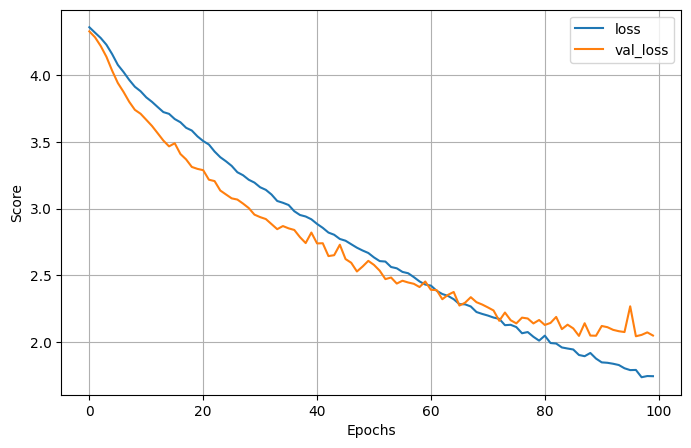

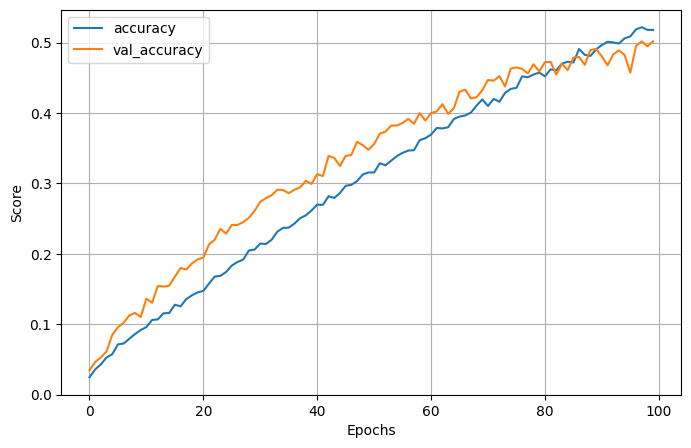

In [23]:
input_shape = (100, 100, 3)
model = build_cnn(input_shape, 83)
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train,
                    validation_data=test, 
                    epochs=100, batch_size=32,  
                    callbacks=[early_stopping_cb])


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')
history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

Apesar de muito simples o modelo chegou a 50% e acuracia em 100 epocas, isso indica quen possivelmente com modelos mais robustos conseguiremos atingir melhores resultados. É interessante refletir se com mais tempo de treino o modelo conseguiria alcançar resultados melhores, mas ao olhar para curva tem-se a oimpressão de que a partir deste ponto estariamos caminhando para um overfitting

## 2.2 Tentando aprimorar o modelo básico

In [24]:
def build_cnn2(input_shape=(100, 100, 3), n_classes=83):
    model = Sequential([
        # feature extraction
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        
        Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        
        Flatten(),
        
        # Fully-Connected Neural Network ==> MLP
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

Epoch 1/100
305/305 [==============================] - 14s 44ms/step - loss: 4.6156 - accuracy: 0.0218 - val_loss: 4.3627 - val_accuracy: 0.0279
Epoch 2/100
305/305 [==============================] - 13s 43ms/step - loss: 4.4028 - accuracy: 0.0266 - val_loss: 4.3142 - val_accuracy: 0.0411
Epoch 3/100
305/305 [==============================] - 13s 43ms/step - loss: 4.3600 - accuracy: 0.0331 - val_loss: 4.3032 - val_accuracy: 0.0562
Epoch 4/100
305/305 [==============================] - 13s 43ms/step - loss: 4.3205 - accuracy: 0.0383 - val_loss: 4.2013 - val_accuracy: 0.0562
Epoch 5/100
305/305 [==============================] - 13s 43ms/step - loss: 4.2905 - accuracy: 0.0351 - val_loss: 4.3035 - val_accuracy: 0.0394
Epoch 6/100
305/305 [==============================] - 13s 43ms/step - loss: 4.2556 - accuracy: 0.0422 - val_loss: 4.1118 - val_accuracy: 0.0608
Epoch 7/100
305/305 [==============================] - 13s 43ms/step - loss: 4.2373 - accuracy: 0.0426 - val_loss: 4.0833 - val_ac

Text(0, 0.5, 'Score')

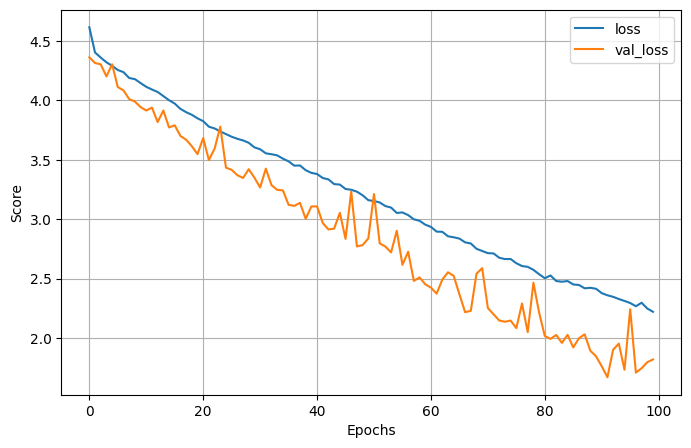

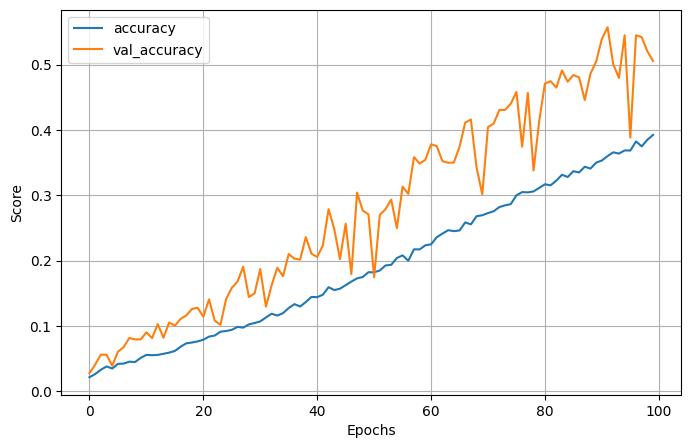

In [25]:
input_shape = (100, 100, 3)
model = build_cnn2(input_shape, 83)
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train,
                    validation_data=test, 
                    epochs=100, batch_size=32,  
                    callbacks=[early_stopping_cb])


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')
history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

## 2.3 Transfer Learning
Uma alternativa interessante neste caso é procurar por modelos já existentes e avaliar o desenpenho deles neste problema a partir de um treino em novas camadas finais.
Alguns modelos a serem testados: MobileNet , VGG16, MobileNetV2, DenseNet169, DenseNet201, DenseNet121,VGG19,Xception

### 2.3.1 Testando vários modelos

In [3]:
# Dictionary with the models
models = {
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}


In [4]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    #pretrained_model = model(include_top=False, weights="imagenet", input_shape=(224,224,3))
    
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(83, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [5]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

Como nosso input_shape é 100x100 vamos converte-lo para 224x224 para usarmos os modelos pré treinados em 100 epocas

In [6]:
train, test = gerar_treino_teste(224,224)

Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.


In [7]:
# Fit the models
for name, model in models.items():
        # Get the model
        m = get_model(model['model'])
        models[name]['model'] = m

        start = perf_counter()

        # Fit the model
        history = m.fit(train,validation_data=test,epochs = 10,verbose=0, callbacks=[early_stopping_cb])

        # Sav the duration and the val_accuracy
        duration = perf_counter() - start
        duration = round(duration,2)
        models[name]['perf'] = duration
        print(f"{name:20} trained in {duration} sec")

        val_acc = history.history['val_accuracy']
        models[name]['val_acc'] = [round(v,4) for v in val_acc]


MobileNet            trained in 555.85 sec
MobileNetV2          trained in 671.54 sec
DenseNet169          trained in 622.93 sec
DenseNet201          trained in 1061.52 sec
DenseNet121          trained in 666.55 sec
VGG16                trained in 572.01 sec
VGG19                trained in 538.61 sec
Xception             trained in 553.77 sec


In [10]:
df = pd.read_csv('train.csv')

labels = df['label']
    
dataset_df_full_train, dataset_df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=labels)
    

In [12]:
from sklearn.metrics import classification_report,accuracy_score


In [22]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,MobileNet,0.4327,555.85
1,DenseNet169,0.3559,622.93
2,MobileNetV2,0.3420,671.54
3,DenseNet201,0.3358,1061.52
4,DenseNet121,0.3087,666.55
5,Xception,0.2578,553.77
6,VGG16,0.2147,572.01
7,VGG19,0.1872,538.61


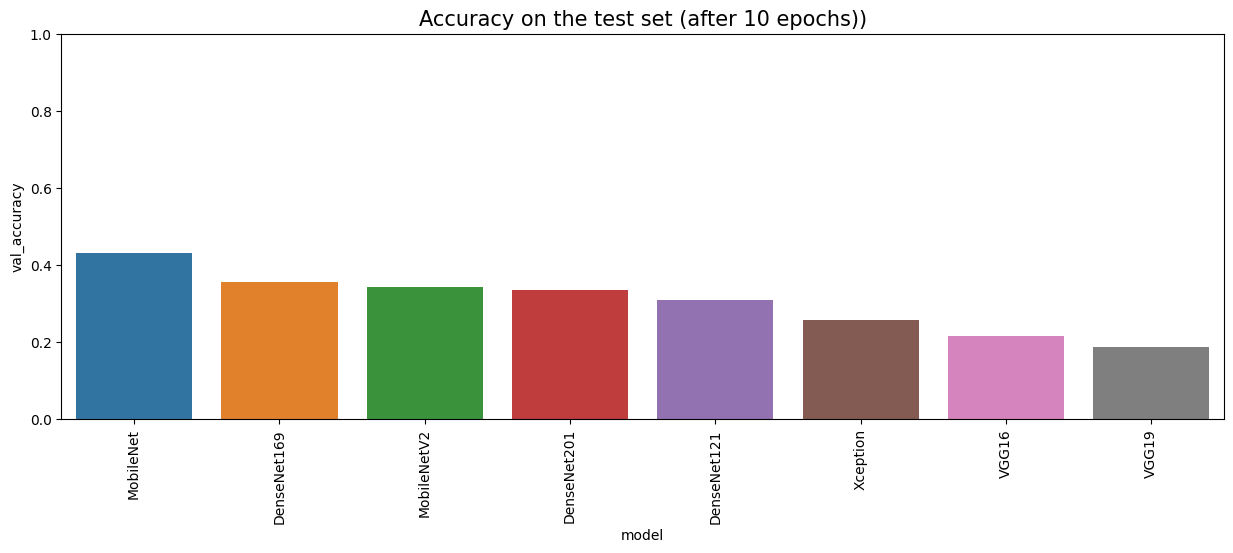

In [23]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the test set (after 10 epochs))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

Apesar de termos treinado em poucas epocas vamos testar a melhorar a variante dos modelos e tentar aprimorar elas, neste caso vamos avançar com MobiliNet , MobileNetV2 e VGG16 (Para variar os modelos)

#### 2.3.1.1 MobileNet

In [26]:
from tensorflow.keras.applications import MobileNet


trained_model = MobileNet(input_shape=(224,224,3),           
                    include_top=False,
                    weights='imagenet')   


for layer in trained_model.layers:
    layer.trainable = False
    
trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [27]:
last_layer=trained_model.get_layer('conv_pw_13_relu')   
last_layer_output=last_layer.output

In [28]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(83,activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=['accuracy'])
#Summary of the model.
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [29]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train,
                     validation_data=test,
                     epochs=100,
                     callbacks=[early_stopping_cb],
                     verbose=1)

Epoch 1/100
305/305 [==============================] - 41s 131ms/step - loss: 15.8826 - accuracy: 0.0490 - val_loss: 7.4433 - val_accuracy: 0.1806
Epoch 2/100
305/305 [==============================] - 24s 80ms/step - loss: 18.4624 - accuracy: 0.0712 - val_loss: 8.1585 - val_accuracy: 0.1790
Epoch 3/100
305/305 [==============================] - 24s 79ms/step - loss: 19.6427 - accuracy: 0.0770 - val_loss: 8.7935 - val_accuracy: 0.1827
Epoch 4/100
305/305 [==============================] - 24s 79ms/step - loss: 20.3474 - accuracy: 0.0820 - val_loss: 8.0537 - val_accuracy: 0.2209
Epoch 5/100
305/305 [==============================] - 24s 78ms/step - loss: 20.6771 - accuracy: 0.0868 - val_loss: 7.9988 - val_accuracy: 0.2336
Epoch 6/100
305/305 [==============================] - 24s 78ms/step - loss: 20.8956 - accuracy: 0.0857 - val_loss: 8.8704 - val_accuracy: 0.2245
Epoch 7/100
305/305 [==============================] - 24s 78ms/step - loss: 21.2942 - accuracy: 0.0931 - val_loss: 9.7450 

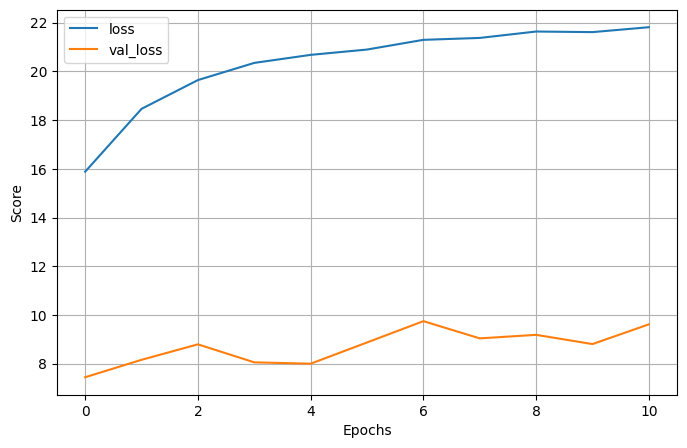

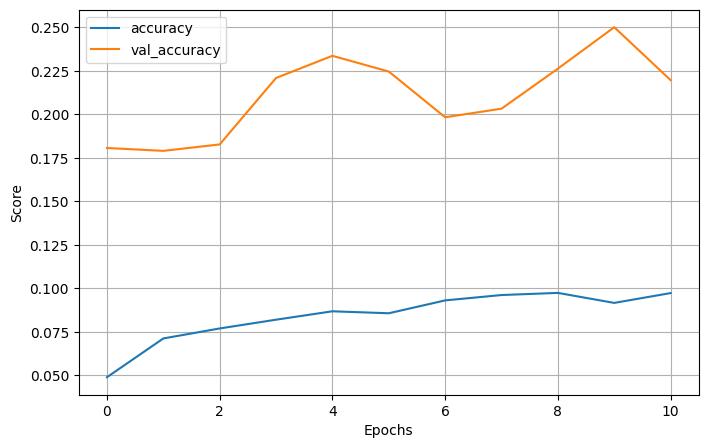

In [30]:
graficos(history)

#### 2.3.1.2 MobileNetV2

In [31]:
from tensorflow.keras.applications import MobileNetV2

In [32]:
train, test = gerar_treino_teste(224,224)

Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.


In [33]:
trained_model=MobileNetV2(input_shape=(224,224,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable = True
    
trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [34]:
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output

In [35]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(83,activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
#Summary of the model.
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [36]:
#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#Salvamos os pessos aprendidos durante o treinamento
checkpoint = ModelCheckpoint("MobileNetV2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


# Fit the model
train_generator, test_generator = gerar_treino_teste(224,224)


history = model.fit(train,
                     validation_data=test,
                     epochs=25,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.
Epoch 1/100
305/305 [==============================] - ETA: 0s - loss: 4.6135 - accuracy: 0.0218
Epoch 1: val_loss improved from inf to 4.40911, saving model to MobileNetV2.h5
305/305 [==============================] - 428s 1s/step - loss: 4.6135 - accuracy: 0.0218 - val_loss: 4.4091 - val_accuracy: 0.0419
Epoch 2/100
305/305 [==============================] - ETA: 0s - loss: 4.2145 - accuracy: 0.0515
Epoch 2: val_loss improved from 4.40911 to 4.22061, saving model to MobileNetV2.h5
305/305 [==============================] - 427s 1s/step - loss: 4.2145 - accuracy: 0.0515 - val_loss: 4.2206 - val_accuracy: 0.0665
Epoch 3/100
305/305 [==============================] - ETA: 0s - loss: 3.8435 - accuracy: 0.1062
Epoch 3: val_loss improved from 4.22061 to 4.01186, saving model to MobileNetV2.h5
305/305 [==============================] - 427s 1s/step - loss: 3.8435 - acc

KeyboardInterrupt: 

In [38]:
# Loads the weights
model.load_weights("MobileNetV2.h5")



In [61]:
classes=train.class_indices
class_names=list(classes.keys()) 

In [60]:
df = pd.read_csv('train.csv')

labels = df['label']
    
dataset_df_full_train, dataset_df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=labels)
dataset_df_test.reset_index(inplace=True,drop = True)

In [62]:
def predict(path):
      #List of the class names
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(224, 224)
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    img_array=img_array/255.

    score = model.predict(img_array)

    return class_names[np.argmax(score)]

In [68]:
dataset_df_test["Previsto"] = dataset_df_test.apply(lambda row: predict(row["image-pathname"]),axis = 1)

1/1 [==============================] - 0s 13ms/step


In [69]:
dataset_df_test

,image-pathname,label,Previsto
0,train/Daniel Craig/70.jpg,Daniel Craig,Daniel Craig
1,train/Victoria Beckham/87.jpg,Victoria Beckham,Halle Berry
2,train/Barack Obama/230.jpg,Barack Obama,Barack Obama
3,train/Dustin Hoffman/159.jpg,Dustin Hoffman,Dustin Hoffman
4,train/Miley Cyrus/927.jpg,Miley Cyrus,Miley Cyrus
...,...,...,...
2431,train/Morgan Freeman/22.jpg,Morgan Freeman,Morgan Freeman
2432,train/Halle Berry/331.jpg,Halle Berry,Eva Mendes
2433,train/George Clooney/492.jpg,George Clooney,George Clooney
2434,train/Reese Witherspoon/32.jpg,Reese Witherspoon,Meg Ryan


In [70]:
dataset_df_test["label"].values

array(['Daniel Craig', 'Victoria Beckham', 'Barack Obama', ...,
       'George Clooney', 'Reese Witherspoon', 'Jack Nicholson'],
      dtype=object)

In [72]:
print(classification_report(dataset_df_test["label"].values, dataset_df_test["Previsto"].values, target_names=[name for name in class_names]))

                      precision    recall  f1-score   support

        Adam Sandler       0.84      0.89      0.86        18
        Alec Baldwin       1.00      0.88      0.94        17
      Angelina Jolie       0.91      0.77      0.83        39
     Anna Kournikova       0.86      0.80      0.83        30
      Ashton Kutcher       0.73      0.69      0.71        16
       Avril Lavigne       0.87      0.98      0.92        56
        Barack Obama       0.98      0.96      0.97        50
         Ben Affleck       1.00      0.74      0.85        19
     Beyonce Knowles       1.00      0.81      0.89        21
           Brad Pitt       0.89      0.89      0.89        56
        Cameron Diaz       0.93      0.91      0.92        45
      Cate Blanchett       0.91      0.75      0.82        28
     Charlize Theron       0.84      0.89      0.86        35
     Christina Ricci       0.82      0.72      0.77        25
    Claudia Schiffer       1.00      0.75      0.86        20
       

#### 2.3.1.3 VGG16

In [ ]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 
train, test = gerar_treino_teste(img_rows,img_cols)
# Re-loads the VGG16 model without the top or FC layers
model = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "sigmoid")(top_model)
    return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

num_classes = 83

FC_Head = addTopModel(model, num_classes)

modelnew = Model(inputs=model.input, outputs=FC_Head)

print(modelnew.summary())

In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
#Salvamos os pessos aprendidos durante o treinamento
checkpoint = ModelCheckpoint("face_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [ ]:
modelnew.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = modelnew.fit(train,
                     validation_data=test,
                     epochs=100,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

In [ ]:
graficos(history)

### 2.3.2 Testando outros modelos prontos.
#### 2.3.2.1 VGGFace
Neste caso vamos testar VGGFace que já foi treinado par reconhecimento de faces, em muitos casos ele pode dar erro de importação (`ModuleNotFoundError: No module named 'keras.engine.topology'`) como no meu caso. Para resolver isso devemos substituir o trecho de código:

`from keras.engine.topology import get_source_inputs`

por

`from keras.utils.layer_utils import get_source_inputs`

No arquivo C:\Users\User\.conda\envs\tf\Lib\site-packages\keras_vggface\models.py


In [12]:
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the base pre-trained model
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(83, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#Salvamos os pessos aprendidos durante o treinamento
checkpoint = ModelCheckpoint("VGG_Face.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


# Fit the model
train_generator, test_generator = gerar_treino_teste(224,224)

history = model.fit(train_generator,
                     validation_data=test_generator,
                     epochs=20,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)


Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.
Epoch 1/20
305/305 [==============================] - ETA: 0s - loss: 3.2064 - accuracy: 0.2737
Epoch 1: val_loss improved from inf to 2.14830, saving model to VGG_Face.h5
305/305 [==============================] - 78s 254ms/step - loss: 3.2064 - accuracy: 0.2737 - val_loss: 2.1483 - val_accuracy: 0.8658
Epoch 2/20
305/305 [==============================] - ETA: 0s - loss: 1.5054 - accuracy: 0.6238
Epoch 2: val_loss improved from 2.14830 to 0.32735, saving model to VGG_Face.h5
305/305 [==============================] - 53s 175ms/step - loss: 1.5054 - accuracy: 0.6238 - val_loss: 0.3274 - val_accuracy: 0.9466
Epoch 3/20
305/305 [==============================] - ETA: 0s - loss: 1.0105 - accuracy: 0.7408
Epoch 3: val_loss improved from 0.32735 to 0.19598, saving model to VGG_Face.h5
305/305 [==============================] - 54s 175ms/step - loss: 1.0105 - accuracy:

In [ ]:
graficos(history)

#### 2.3.2.2 DeepFace

Assim como vggface o DeepFace foi treinado com imagen de rostos de pessoas portanto espera-se um bom desempenho dele

In [73]:
from deepface import DeepFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Create a DeepFace base model
base_model = DeepFace.build_model('VGG-Face')

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

#Salvamos os pessos aprendidos durante o treinamento
checkpoint = ModelCheckpoint("DeepFace.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


# Fit the model
train_generator, test_generator = gerar_treino_teste(224,224)




Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.


In [ ]:

history = model.fit(train_generator,
                     validation_data=test_generator,
                     epochs=100,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

In [74]:
# Loads the weights
model.load_weights("DeepFace.h5")



In [75]:
classes=train.class_indices
class_names=list(classes.keys()) 

In [76]:
def predict_2(path):
      #List of the class names
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(224, 224)
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    img_array=img_array/255.

    score = model.predict(img_array)

    return class_names[np.argmax(score)]

In [77]:
dataset_df_test["Previsto 2"] = dataset_df_test.apply(lambda row: predict_2(row["image-pathname"]),axis = 1)

1/1 [==============================] - 0s 14ms/step


In [78]:
dataset_df_test

,image-pathname,label,Previsto,Previsto 2
0,train/Daniel Craig/70.jpg,Daniel Craig,Daniel Craig,Daniel Craig
1,train/Victoria Beckham/87.jpg,Victoria Beckham,Halle Berry,Victoria Beckham
2,train/Barack Obama/230.jpg,Barack Obama,Barack Obama,Barack Obama
3,train/Dustin Hoffman/159.jpg,Dustin Hoffman,Dustin Hoffman,Dustin Hoffman
4,train/Miley Cyrus/927.jpg,Miley Cyrus,Miley Cyrus,Miley Cyrus
...,...,...,...,...
2431,train/Morgan Freeman/22.jpg,Morgan Freeman,Morgan Freeman,Morgan Freeman
2432,train/Halle Berry/331.jpg,Halle Berry,Eva Mendes,Halle Berry
2433,train/George Clooney/492.jpg,George Clooney,George Clooney,George Clooney
2434,train/Reese Witherspoon/32.jpg,Reese Witherspoon,Meg Ryan,Reese Witherspoon


In [79]:
print(classification_report(dataset_df_test["label"].values, dataset_df_test["Previsto 2"].values, target_names=[name for name in class_names]))

                      precision    recall  f1-score   support

        Adam Sandler       1.00      1.00      1.00        18
        Alec Baldwin       1.00      0.94      0.97        17
      Angelina Jolie       0.94      0.87      0.91        39
     Anna Kournikova       0.96      0.90      0.93        30
      Ashton Kutcher       0.94      1.00      0.97        16
       Avril Lavigne       0.96      0.96      0.96        56
        Barack Obama       1.00      1.00      1.00        50
         Ben Affleck       0.95      1.00      0.97        19
     Beyonce Knowles       0.95      0.95      0.95        21
           Brad Pitt       0.98      0.98      0.98        56
        Cameron Diaz       0.98      0.96      0.97        45
      Cate Blanchett       0.97      1.00      0.98        28
     Charlize Theron       0.92      1.00      0.96        35
     Christina Ricci       0.89      0.96      0.92        25
    Claudia Schiffer       0.90      0.95      0.93        20
       

# 3. Treinamento do modelo final
Como pudemos ver os melhores modelos gerados foram facenet, vggFace e MobileNetV2.
Sendo assim vamos treinar os três modelos e usar os três modelos para a classificação final. 

In [15]:
def gerar_treino(rows,cols):
    # read the dataframe
    df = pd.read_csv('train.csv')
    
    # iterate over the images
    for i, row in df.iterrows():
        # read the image
        img = cv2.imread(row['image-pathname'])

        # check if the image was correctly opened
        if img is not None:
            # resize the image
            img = cv2.resize(img, (rows, cols))

            # save the image back to disk
            cv2.imwrite(row['image-pathname'], img)
        else:
            print(f"Image not found: {row['image-pathname']}")
    

    #Gerar dados de treinamento
    train_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 brightness_range=(0.8, 1.2),
                                 fill_mode='nearest')
                                 

    train_generator = train_datagen.flow_from_dataframe(dataframe=df,
                                                        x_col="image-pathname",
                                                        y_col="label",
                                                        target_size=(rows,cols),
                                                        class_mode='categorical')

    
    
    
    
    return train_generator

In [16]:
train = gerar_treino(224,224)

Found 12180 validated image filenames belonging to 83 classes.


## 3.1 MobileNetV2

In [17]:
from tensorflow.keras.applications import MobileNetV2
trained_model=MobileNetV2(input_shape=(224,224,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable = True
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(83,activation='softmax')(x)

model_mobile = tf.keras.Model(trained_model.input,x) 

model_mobile.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

#Salvamos os pessos aprendidos durante o treinamento
checkpoint = ModelCheckpoint("MobileNetV2_final.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)



history = model_mobile.fit(train,
                     epochs=40,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

Epoch 1/40
381/381 [==============================] - 98s 252ms/step - loss: 4.5531 - accuracy: 0.0250
Epoch 2/40
381/381 [==============================] - 70s 183ms/step - loss: 4.1754 - accuracy: 0.0626
Epoch 3/40
381/381 [==============================] - 69s 182ms/step - loss: 3.7697 - accuracy: 0.1161
Epoch 4/40
381/381 [==============================] - 69s 181ms/step - loss: 3.2130 - accuracy: 0.2140
Epoch 5/40
381/381 [==============================] - 69s 182ms/step - loss: 2.6572 - accuracy: 0.3236
Epoch 6/40
381/381 [==============================] - 69s 182ms/step - loss: 2.2008 - accuracy: 0.4214
Epoch 7/40
381/381 [==============================] - 69s 182ms/step - loss: 1.8210 - accuracy: 0.5174
Epoch 8/40
381/381 [==============================] - 69s 182ms/step - loss: 1.5193 - accuracy: 0.5930
Epoch 9/40
381/381 [==============================] - 69s 182ms/step - loss: 1.3040 - accuracy: 0.6463
Epoch 10/40
381/381 [==============================] - 69s 182ms/step - l

## 3.2 VGGFace

In [21]:
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the base pre-trained model
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(83, activation='softmax')(x)

# This is the model we will train
model_vgggface = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (should be done *after* setting layers to non-trainable)
model_vgggface.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

#Salvamos os pessos aprendidos durante o treinamento
checkpoint = ModelCheckpoint("VGG_Face_final.h5",
                             monitor="loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


history = model_vgggface.fit(train,
                     epochs=40,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

Epoch 1/40
381/381 [==============================] - ETA: 0s - loss: 3.2493 - accuracy: 0.2685WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy

Epoch 1: loss improved from inf to 3.24925, saving model to VGG_Face_final.h5
381/381 [==============================] - 70s 184ms/step - loss: 3.2493 - accuracy: 0.2685
Epoch 2/40
381/381 [==============================] - ETA: 0s - loss: 1.6138 - accuracy: 0.5933WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy

Epoch 2: loss improved from 3.24925 to 1.61380, saving model to VGG_Face_final.h5
381/381 [==============================] - 70s 184ms/step - loss: 1.6138 - accuracy: 0.5933
Epoch 3/40
381/381 [==============================] - ETA: 0s - loss: 1.1347 - accuracy: 0.7042WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are:

## 3.3 FaceNet

In [22]:
from deepface import DeepFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Create a DeepFace base model
base_model = DeepFace.build_model('VGG-Face')

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(83, activation='softmax')(x)

# This is the model we will train
model_facenet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_facenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

#Salvamos os pessos aprendidos durante o treinamento
checkpoint = ModelCheckpoint("DeepFace_final.h5",
                             monitor="loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

history = model_facenet.fit(train,
                     epochs=40,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

Epoch 1/40
381/381 [==============================] - ETA: 0s - loss: 3.9852 - accuracy: 0.1646
Epoch 1: loss improved from inf to 3.98517, saving model to DeepFace_final.h5
381/381 [==============================] - 74s 190ms/step - loss: 3.9852 - accuracy: 0.1646
Epoch 2/40
381/381 [==============================] - ETA: 0s - loss: 3.1056 - accuracy: 0.3544
Epoch 2: loss improved from 3.98517 to 3.10562, saving model to DeepFace_final.h5
381/381 [==============================] - 71s 185ms/step - loss: 3.1056 - accuracy: 0.3544
Epoch 3/40
381/381 [==============================] - ETA: 0s - loss: 2.4505 - accuracy: 0.5266
Epoch 3: loss improved from 3.10562 to 2.45048, saving model to DeepFace_final.h5
381/381 [==============================] - 70s 184ms/step - loss: 2.4505 - accuracy: 0.5266
Epoch 4/40
381/381 [==============================] - ETA: 0s - loss: 1.9712 - accuracy: 0.6359
Epoch 4: loss improved from 2.45048 to 1.97115, saving model to DeepFace_final.h5
381/381 [=======

## 3.4 Classificação final

In [23]:
classes=train.class_indices
class_names=list(classes.keys()) 

In [24]:
df_test = pd.read_csv('test.csv')

In [25]:
df_test.head()

,image-id,image-pathname
0,1,test/0001.jpg
1,2,test/0002.jpg
2,3,test/0003.jpg
3,4,test/0004.jpg
4,5,test/0005.jpg


In [26]:
def predict(path, modeloo):
      #List of the class names
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(224, 224)
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    img_array=img_array/255.

    score = modeloo.predict(img_array)

    return class_names[np.argmax(score)]

In [36]:
df_test["Mobile"] = df_test.apply(lambda row: predict(row["image-pathname"], model_mobile),axis = 1)

1/1 [==============================] - 0s 12ms/step


In [32]:
df_test["VGGFace"] = df_test.apply(lambda row: predict(row["image-pathname"], model_vgggface),axis = 1)

1/1 [==============================] - 0s 12ms/step


In [33]:
df_test["FaceNet"] = df_test.apply(lambda row: predict(row["image-pathname"], model_facenet),axis = 1)

1/1 [==============================] - 0s 12ms/step


In [37]:
df_test

,image-id,image-pathname,Mobile,VGGFace,FaceNet
0,1,test/0001.jpg,Eva Mendes,Faith Hill,Faith Hill
1,2,test/0002.jpg,Brad Pitt,Daniel Craig,Daniel Craig
2,3,test/0003.jpg,Ben Affleck,Steve Carell,Steve Carell
3,4,test/0004.jpg,Brad Pitt,Alec Baldwin,Alec Baldwin
4,5,test/0005.jpg,Daniel Craig,Michael Bloomberg,Michael Bloomberg
...,...,...,...,...,...
1655,1656,test/1656.jpg,Hugh Laurie,Stephen Colbert,Stephen Colbert
1656,1657,test/1657.jpg,Brad Pitt,Kate Winslet,Kate Winslet
1657,1658,test/1658.jpg,Mariah Carey,Mariah Carey,Mariah Carey
1658,1659,test/1659.jpg,Jennifer Aniston,Jennifer Aniston,Jennifer Aniston


In [38]:
def classificacao_final(row):
    if row["VGGFace"] == row["FaceNet"]:
        return row["VGGFace"]
    elif row["VGGFace"] == row["Mobile"]:
        return row["VGGFace"]
    elif row["FaceNet"] == row["Mobile"]:
        return row["FaceNet"]
    else:
        return row["VGGFace"]

In [39]:
df_test["prediction"] = df_test.apply(lambda row: classificacao_final(row),axis = 1)

In [41]:
df_test = df_test[["image-id" , "prediction"]]

In [43]:
df_test.to_csv("entrega.csv",index = False)

# 4. Conclusões 🎯

Neste trabalho, vivenciei de perto o lema "se tiver tempo, teste". 🕐🔬 Dias foram investidos na configuração da minha máquina para habilitar o uso da GPU, na instalação de recursos um pouco desatualizados no Python, e em manipulações extensas de código para obter resultados satisfatórios para o problema de reconhecimento facial. 🖥️🐍

Fiquei verdadeiramente surpreso com o desempenho da rede mais simples - que atingiu uma precisão de 50%, sendo tão básica. 🥳💻 No entanto, confesso que senti um pouco de decepção com alguns modelos de transfer learning. Meu entusiasmo para testar inúmeras possibilidades resultou em uma ligeira perda de foco com o tempo, mas, de maneira geral, considero o resultado final satisfatório.👍

Minha vontade era de ter experimentado mais classificadores no final das redes de transfer learning. Porém, os treinamentos estavam consumindo um tempo considerável, mesmo com a assistência da GPU. ⏳⚡ Uma situação semelhante ocorreu com os otimizadores. No código apresentado, é possível observar que alguns treinamentos foram interrompidos intencionalmente, dado que não havia ganhos significativos após algumas épocas.🚦🛑

Testei ainda alguns outros modelos que, infelizmente, apresentaram resultados inferiores e me desapontaram. 😞📉

Se fosse começar hoje novamente neste trabalho, sem dúvida, tomaria como ponto de partida as redes VGGFace e Facenet. 🚀🌐 Além disso, faria uma busca mais ampla por modelos que oferecessem performance tão alta quanto esses, para que a estratégia de ensemble learning fosse mais efetiva. 🧠🔍

A ideia do majority voting no final parece ser uma abordagem promissora, mas para isso, é preciso contar com ao menos três modelos com acurácias semelhantes. No presente caso, isso não ocorreu, pois o modelo MobilenetV2 ficou ligeiramente abaixo dos demais. 💭🏁

Em resumo, esta experiência reforçou a importância da experimentação e da paciência na ciência de dados. Estou ansioso para aplicar as lições aprendidas em futuros projetos! 🎉🚀